In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


# TODO:

- Experiment with multi-envs:
    * https://stable-baselines.readthedocs.io/en/master/guide/examples.html?highlight=set_global_seeds#multiprocessing-unleashing-the-power-of-vectorized-environments
    * Notes: https://github.com/hill-a/stable-baselines/issues/334, https://github.com/hill-a/stable-baselines/issues/166, https://github.com/hill-a/stable-baselines/issues/308
    - Consider this as two separate points for MLP and LSTM. Different requirements (see other point)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html. Will need to assess if model is still unstable.
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt. Some Medium articles uses Sharpe values, investigate.
- Download all transactions -> render OHLC in multiple time granularities
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- self.stationarize_rewards?
- Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Hyperparameter search
- Explore different gamma (Discount factor)
- Checkout frame stacking as a poor man's lstm (unlikely that it's useful, since we're dealing with time series)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better (need to understand terminology surronding it, e.g. environment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- understand the rendering during learning (prob need to read the code to understand all callback fields)
- untangle index weirdness (basically, try to enable prediction the last timestep, and make running interface easier (and more robust))
    * Check info box for reason and solution: https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html
    * This might also help (at the end) https://github.com/hill-a/stable-baselines/issues/779
    * LOW PRIO, since we might change the padding structure if we apply LSTM policy network

- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks

# Run

In [2]:
%%time
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df)
env = run.setup_env(df=df)
timesteps = config.train_predict.train_timesteps
model = run.train(env=env, timesteps=timesteps)

LOAD: Loading data with 2099760 samples
PREPROCESS: Dropping 109069 NaNs out of 2099760 samples (5.19%) from input file
PREPROCESS: Dropping unused data, 1990691 -> 3510 samples
PREPROCESS: Adding technical features...
Done.

Resetting to timesteps: start 1987223, end 1990190.
RUN: Training for 3000 timesteps...




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Resetting to timesteps: start 1987223, end 1990190.
--------------------------------------
| approxkl           | 0.00015236964 |
| clipfrac           | 0.0           |
| explained_variance | -1.26         |
| fps                | 91            |
| n_updates          | 1             |
| policy_entropy     | 2.1970954     |
| policy_loss        | -0.007845364  |
| serial_timesteps   | 128           |
| time_elapsed       | 4.55e-05      |
| tot

RUN: Loading files from /tmp/
Loading a model without an environment, this model cannot be trained until it has a valid environment.
RUN: Model connected with env
RUN: Predicting for 489 timesteps
Resetting to timesteps: start 1990200, end 1990690.
Rendering TradingChartStatic for index steps 1990200 through 1990689


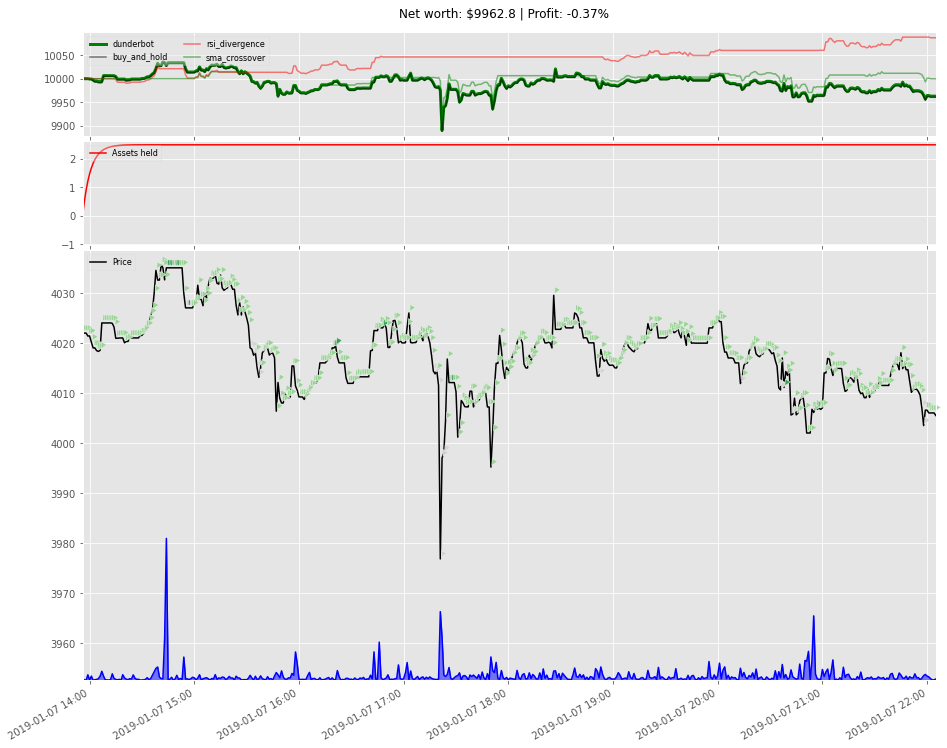

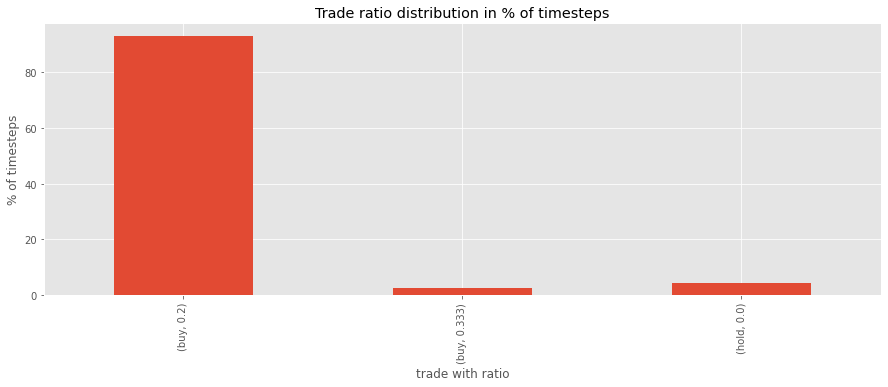

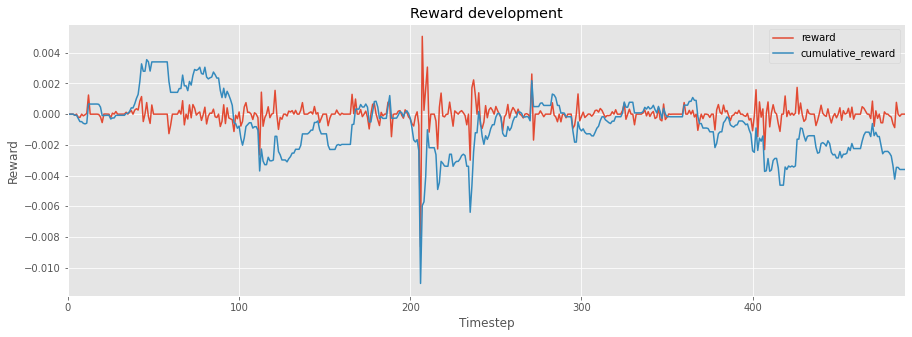

CPU times: user 22.4 s, sys: 1.2 s, total: 23.6 s
Wall time: 23.1 s


In [4]:
%%time
timesteps = config.train_predict.predict_timesteps - config.data_params.data_n_timesteps - 1
run.predict(df=df, timesteps=timesteps, rendermode='human')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 18,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10001.7,
  9993.31,
  9845.08,
  9818.83,
  9857.64,
  9811.18,
  9826.9,
  9849.13,
  9841.65,
  9846.6,
  9906.72,
  9857.82,
  9825.55,
  9844.28,
  9835.73,
  9843.79,
  9853.91,
  9847.28,
  9858.84,
  9884.08,
  9846.62,
  9846.11,
  9859.04,
  9865.74,
  9849.82,
  9871.96,
  9886.04,
  9852.41,
  9828.36,
  9781.67,
  9796.26,
  9789.61,
  9787.16,
  9798.66,
  9821.71,
  9819.04,
  9825.21,
  9813.02,
  9817.28,
  9809.9,
  9810.35,
  9815.73,
  9852.16,
  9844.47,
  9845.15,
  9833.28,
  9836.58,
  9863.32,
  9843.26,
  9846.9,
  9838.6,
  9843.73,
  9840.44,
  9971.54,
  9981.18,
  9980.54,
  9981.68,
  9980.22,
  9984.06,
  10005.04,
  9992.58,
  9998.53,
  10012.4,
  10006.93,
  9995.75,
  9951.78,
  9922.8,
  9824.37,
  9840.96,
  9803.94,
  9764.1,
  9780.03,
  9798.29,
  9787.19,
  9793.24,
  9805.33,
  9789.97,
  9796.14,
  9795.5,
  9814.97,
  9812.16,
  9803.83,
  9817.89,
  9804.12,
  9807.79,
  9

In [8]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])

# Testing TIs

In [51]:
import ta
import pandas as pd

In [54]:
df = load.load_OHLC_data()

In [55]:
df = preprocess.preprocess_data(df=df)

Dropping 109069 NaNs out of 2099760 samples (5.19%) from input file
Dropping unused data, 1990691 -> 3520 samples


## BB

In [9]:
bb = ta.volatility.BollingerBands(close=df['Close'], n=20, ndev=2)


df['bb_hi'] = bb.bollinger_hband_indicator()
df['bb_li'] = bb.bollinger_lband_indicator()
df['bb_width'] = bb.bollinger_wband()

In [5]:
df.head(22)

,index,Symbol,Open,High,Low,Close,VolumeBTC,VolumeUSD,Timestamp
0,0,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53,2014-12-01
1,1,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07,2014-12-02
2,2,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52,2014-12-03
3,3,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77,2014-12-04
4,4,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00,2014-12-05
5,5,BTCUSD,377.1,378.0,377.10,378.0,0.01500,5.67,2014-12-06
6,6,BTCUSD,378.0,378.0,378.00,378.0,0.00000,0.00,2014-12-07
7,7,BTCUSD,378.0,378.0,375.00,375.0,0.23500,88.13,2014-12-08
8,8,BTCUSD,375.0,375.0,375.00,375.0,0.00000,0.00,2014-12-09
9,9,BTCUSD,375.0,398.0,360.50,360.5,0.02000,7.59,2014-12-10


## PSAR

In [6]:
psar = ta.trend.PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'])

In [9]:
df['psar_up'] = psar.psar_up_indicator()
df['psar_down'] = psar.psar_down_indicator()

<AxesSubplot:>

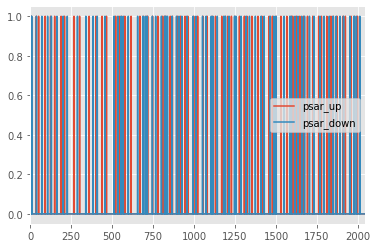

In [12]:
df[['psar_up', 'psar_down']].plot()

In [13]:
adx = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'])

In [14]:
df['adx'] = adx.adx()
df['adx_neg'] = adx.adx_neg()
df['adx_pos'] = adx.adx_pos()

In [15]:
df

,index,Symbol,Open,High,Low,Close,VolumeBTC,VolumeUSD,Timestamp,psar_lo,psar_up,psar_down,adx,adx_neg,adx_pos
0,0,BTCUSD,300.00,370.00,300.00,370.00,0.05656,19.53,2014-12-01,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,1,BTCUSD,370.00,378.00,370.00,378.00,15.01000,5675.07,2014-12-02,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2,BTCUSD,378.00,378.00,377.01,378.00,0.54660,206.52,2014-12-03,1.0,0.0,1.0,0.000000,0.000000,0.000000
3,3,BTCUSD,378.00,378.00,377.10,377.10,0.01000,3.77,2014-12-04,0.0,1.0,0.0,0.000000,0.000000,0.000000
4,4,BTCUSD,377.10,377.10,377.10,377.10,0.00000,0.00,2014-12-05,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,2038,BTCUSD,9235.00,9347.53,9159.33,9303.37,5251.47000,48561605.37,2020-07-12,0.0,0.0,0.0,18.362154,19.784572,16.628423
2039,2039,BTCUSD,9303.37,9339.61,9193.52,9236.92,8653.43000,80253222.67,2020-07-13,0.0,0.0,0.0,17.669689,18.957320,15.933139
2040,2040,BTCUSD,9236.92,9280.00,9100.00,9256.94,7232.38000,66676871.93,2020-07-14,0.0,0.0,0.0,17.524532,20.691874,15.095613
2041,2041,BTCUSD,9256.94,9273.98,9154.01,9190.16,7195.16000,66302380.98,2020-07-15,0.0,0.0,0.0,17.389742,19.939563,14.546770


<AxesSubplot:>

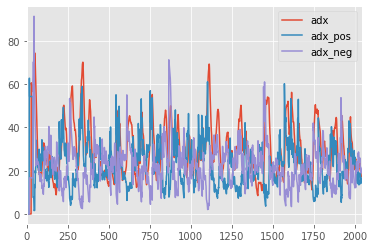

In [17]:
df[['adx', 'adx_pos', 'adx_neg']].plot()

In [42]:
timesteps_needed = config.train_predict.train_timesteps + config.train_predict.predict_timesteps + config.data_params.data_n_timesteps * 2
starting_point = df.index.max() - timesteps_needed + 1

df = df.loc[starting_point:]

In [47]:
df2

,Open,High,Low,Close,VolumeBTC,VolumeUSD,Timestamp,Symbol
1987171,3828.85,3828.85,3828.84,3828.84,3.209150,12287.324735,2019-01-05 11:27:00,BTCUSD
1987172,3828.84,3828.85,3828.84,3828.85,0.518790,1986.362739,2019-01-05 11:28:00,BTCUSD
1987173,3828.85,3834.34,3828.85,3834.12,1.172756,4491.653294,2019-01-05 11:29:00,BTCUSD
1987174,3833.72,3834.24,3832.69,3833.89,1.169513,4483.662827,2019-01-05 11:30:00,BTCUSD
1987175,3831.56,3834.24,3831.56,3834.24,0.197595,757.620083,2019-01-05 11:31:00,BTCUSD
...,...,...,...,...,...,...,...,...
1990686,4006.01,4006.57,4006.00,4006.01,3.382954,13553.433078,2019-01-07 22:02:00,BTCUSD
1990687,4006.01,4006.57,4006.00,4006.01,0.902164,3614.083169,2019-01-07 22:03:00,BTCUSD
1990688,4006.01,4006.01,4006.00,4006.01,1.192123,4775.647308,2019-01-07 22:04:00,BTCUSD
1990689,4006.01,4006.01,4005.50,4005.50,2.699700,10814.241898,2019-01-07 22:05:00,BTCUSD


# Data prep

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
data = pd.read_csv('data/raw/bitstampUSD.csv', header=None) #bitstampUSD.csv, coinbaseUSD.csv

In [3]:
data.columns = ['Timestamp', 'Price', 'VolumeBTC']

In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

In [5]:
data = data.set_index('Timestamp', append=False)


In [ ]:
%%time
price_ohlc = data['Price'].head(1000000).resample('1S').ohlc()

In [ ]:
price_vol = data['VolumeBTC'].resample('1S').sum()